In [1]:
pip install iterative-stratification

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

datapath = "/content/gdrive/My Drive/Datasets/MoA/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
import random as r

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from time import time
import random as r
import seaborn as sns
import math

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, LabelEncoder

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import warnings
warnings.filterwarnings("ignore")

In [4]:
def breaker():
    print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()

def getCol(x):
    return [col for col in x.columns]

def preprocess(x, *args):
    df = x.copy()
    df[args[0]] = df[args[0]].map({"trt_cp" : 0, "ctl_vehicle" : 1})
    df[args[1]] = df[args[1]].map({24 : 0, 48 : 1, 72 : 2})
    df[args[2]] = df[args[2]].map({"D1" : 0, "D2": 1})
    return df

def G_Scale(x=None, mu=None, sigma=None, scale=1, show_disp=True):
    x_Axis = np.arange(-sigma-10,sigma+11)
    func = (1/(sigma * math.sqrt(2*math.pi)) * np.exp(-(x_Axis-mu)**2/(2 * sigma**2))) * scale

    if show_disp:
        plt.figure(figsize=(8,6))
        plt.plot(x_Axis, func, "r")
        plt.xlabel("Samples --->")
        plt.ylabel("Amplitude --->")
        plt.title("Gauss Function Used")
        plt.show()
    return (1/(sigma * math.sqrt(2*math.pi)) * np.exp(-(x-mu)**2/(2 * sigma**2))) * scale

def log_loss_metric(y_true, y_pred, num_classes=206):
  metric = []
  for i in range(num_classes):
    metric.append(log_loss(y_true[:, i], y_pred[:, i], labels=[0, 1], eps=1e-15))
  return sum(metric)/num_classes

sc_X = StandardScaler()
mms  = MinMaxScaler(feature_range=(0, 1))
norms = Normalizer(norm="l1")

NUM_CLASSES  = 206
NUM_FEATURES = 785

In [5]:
top_feats = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
              18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
              32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
              47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
              61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
              74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
              89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
              102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
              115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
              129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
              144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
              158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
              171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
              184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
              198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
              213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
              227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
              240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
              254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
              267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
              281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
              295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
              310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
              324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
              337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
              350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
              363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
              378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
              392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
              405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
              419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
              432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
              447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
              463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
              476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
              490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
              506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
              522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
              538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
              552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
              571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
              586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
              600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
              618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
              631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
              645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
              660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
              673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
              686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
              701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
              718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
              733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
              748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
              762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
              775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
              789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
              804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
              821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
              837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
              854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
              870, 871, 872, 873, 874]

In [6]:
class DS(Dataset):
  def __init__(this, X=None, y=None, mode="train"):
    this.mode = mode
    this.X = X
    if mode == "train":
      this.y = y
  
  def __len__(this):
    return this.X.shape[0]

  def __getitem__(this, idx):
    if this.mode == "train":
      return torch.FloatTensor(this.X[idx]), torch.FloatTensor(this.y[idx])
    else:
      return torch.FloatTensor(this.X[idx])

In [7]:
class CFG():
  tr_batch_size = 128
  va_batch_size = 128
  ts_batch_size = 512

  epochs = 50

  IL = NUM_FEATURES
  HL_1 = [2048]
  HL_2 = [2048, 1024]
  HL_3 = [2048, 1024, 512]
  OL = NUM_CLASSES

  n_folds = 4
  n_seeds = 3

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cfg = CFG()

In [8]:
# FIX: Use dropouts as paramters as well.
 
class ANN(nn.Module):
    def __init__(this, IL=None, HL=None, OL=None):
        super(ANN, this).__init__()

        this.HL = HL
        this.DP1 = nn.Dropout(p=0.35) # 0.2
        this.DP2 = nn.Dropout(p=0.7)  # 0.5

        if len(HL) == 1:
            this.BN1 = nn.BatchNorm1d(IL)
            this.FC1 = WN(nn.Linear(IL, HL[0]))

            this.BN2 = nn.BatchNorm1d(HL[0])
            this.FC2 = WN(nn.Linear(HL[0], OL))

        elif len(HL) == 2:
            this.BN1 = nn.BatchNorm1d(IL)
            this.FC1 = WN(nn.Linear(IL, HL[0]))

            this.BN2 = nn.BatchNorm1d(HL[0])
            this.FC2 = WN(nn.Linear(HL[0], HL[1]))

            this.BN3 = nn.BatchNorm1d(HL[1])
            this.FC3 = WN(nn.Linear(HL[1], OL))

        elif len(HL) == 3:
            this.BN1 = nn.BatchNorm1d(IL)
            this.FC1 = WN(nn.Linear(IL, HL[0]))

            this.BN2 = nn.BatchNorm1d(HL[0])
            this.FC2 = WN(nn.Linear(HL[0], HL[1]))

            this.BN3 = nn.BatchNorm1d(HL[1])
            this.FC3 = WN(nn.Linear(HL[1], HL[2]))

            this.BN4 = nn.BatchNorm1d(HL[2])
            this.FC4 = WN(nn.Linear(HL[2], OL))

        else:
            raise NotImplemetedError("Only supports Networks of Depth 1, 2 and 3")

    def getOptimizer(this, lr=1e-3, wd=0):
        return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)
    
    def forward(this, x):
        if len(this.HL) == 1:
            x = this.BN1(x)
            x = this.DP1(x)
            x = F.relu(this.FC1(x))
            x = this.BN2(x)
            x = this.DP2(x)
            x = torch.sigmoid(this.FC2(x))
            return x
        elif len(this.HL) == 2:
            x = this.BN1(x)
            x = this.DP1(x)
            x = F.relu(this.FC1(x))
            x = this.BN2(x)
            x = this.DP2(x)
            x = F.relu(this.FC2(x))
            x = this.BN3(x)
            x = this.DP2(x)
            x = torch.sigmoid(this.FC3(x))
            return x
        else:
            x = this.BN1(x)
            x = this.DP1(x)
            x = F.relu(this.FC1(x))
            x = this.BN2(x)
            x = this.DP2(x)
            x = F.relu(this.FC2(x))
            x = this.BN3(x)
            x = this.DP2(x)
            x = F.relu(this.FC3(x))
            x = this.BN4(x)
            x = this.DP2(x)
            x = torch.sigmoid(this.FC4(x))
            return x

In [9]:
def train_fn(X=None, y=None, epochs=None, 
             n_folds=None, n_seeds=None, 
             IL=None, HL=None, OL=None,
             device=None, lr=None, wd=None,
             tr_batch_size=None, va_batch_size=None,
             criterion=None):
    breaker()
    print("Training ...")
    breaker()

    LP = []
    names = []
    bestLoss = {"train" : np.inf, "valid" : np.inf}

    r.seed(1729)
    seeders = [r.randint(0,99) for i in range(n_seeds)]
    start_time = time()

    for seed in seeders:
        fold = 0
        for tr_idx, va_idx in MultilabelStratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed).split(X, y):
            print("Processing Seed {seed}, Fold {fold} ...".format(seed=seed, fold=fold+1))

            X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]

            tr_data_setup = DS(X_train, y_train)
            va_data_setup = DS(X_valid, y_valid)

            dataloaders = {"train" : DL(tr_data_setup, batch_size=tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
                            "valid" : DL(va_data_setup, batch_size=va_batch_size, shuffle=False)
                            }

            torch.manual_seed(0)
            model = ANN(IL, HL, OL)
            model.to(device)

            optimizer = model.getOptimizer(lr=lr, wd=wd)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, eps=1e-8, verbose=True)

            for e in range(epochs):
                epochLoss = {"train" : 0, "valid" : 0}
                for phase in ["train", "valid"]:
                    if phase == "train":
                        model.train()
                    else:
                        model.eval()
                    lossPerPass = 0

                    for feats, label in dataloaders[phase]:
                        feats, label = feats.to(device), label.to(device)

                        optimizer.zero_grad()
                        with torch.set_grad_enabled(phase == "train"):
                            output = model(feats)
                            loss   = criterion(output, label)
                            if phase == "train":
                                loss.backward()
                                optimizer.step()
                        lossPerPass = (loss.item()/label.shape[0])
                    epochLoss[phase] = lossPerPass
                LP.append(epochLoss)
                scheduler.step(epochLoss["valid"])
                name = "./Model_{ids}_Fold_{fold}_Seed_{seed}.pt".format(ids=len(HL), fold=fold, seed=seed)
                names.append(name)
                torch.save(model.state_dict(), name)
                if epochLoss["valid"] < bestLoss["valid"]:
                    bestLoss = epochLoss
            #name = "Model_Fold_{fold}_Seed_{seed}.pt".format(fold=fold, seed=seed)
            #names.append(name)
            #torch.save(model.state_dict(), datapath+name)
            fold += 1

    breaker()
    print("Time Taken to Train {n} folds for {e} epochs : {:.2f} minutes".format((time()-start_time)/60, n=n_folds, e=epochs))
    breaker()
    print("Best Loss (Train) : {}".format(bestLoss["train"] * tr_batch_size))
    print("Best Loss (Valid) : {}".format(bestLoss["valid"] * va_batch_size))
    breaker()
    print("Training Completed")
    breaker()
        
    return LP, names, model

def eval_fn(model=None, names=None, dataloader=None, num_obs=None, device=None, ts_batch_size=None):
    y_pred = np.zeros((num_obs, NUM_CLASSES))

    for name in names:
        Pred = torch.zeros(ts_batch_size, NUM_CLASSES).to(device)
        model.load_state_dict(torch.load(name))
        model.eval()
        for feat in dataloader:
            feat = feat.to(device)
            with torch.no_grad():
                Prob = model(feat)
            Pred = torch.cat((Pred, Prob), dim=0)
        Pred = Pred[ts_batch_size:]
        Pred = Pred.cpu().numpy()
        y_pred = np.add(y_pred, Pred)
    y_pred = np.divide(y_pred, len(names))
    return y_pred

def ensemble_2_fn(model_1=None, model_2=None, 
                  names_1=None, names_2=None, 
                  dataloader=None, num_obs=None,
                  device=None, ts_batch_size=None):
    
    y_pred_1 = np.zeros((num_obs, NUM_CLASSES))
    y_pred_2 = np.zeros((num_obs, NUM_CLASSES))

    for name in names_1:
        Pred = torch.zeros(ts_batch_size, NUM_CLASSES).to(device)
        model_1.load_state_dict(torch.load(name))
        model_1.eval()
        for feat in dataloader:
            feat = feat.to(device)
            with torch.no_grad():
                Prob = model_1(feat)
            Pred = torch.cat((Pred, Prob), dim=0)
        Pred = Pred[ts_batch_size:]
        Pred = Pred.cpu().numpy()
        y_pred_1 = np.add(y_pred_1, Pred)

    for name in names_2:
        Pred = torch.zeros(ts_batch_size, NUM_CLASSES).to(device)
        model_2.load_state_dict(torch.load(name))
        model_2.eval()
        for feat in dataloader:
            feat = feat.to(device)
            with torch.no_grad():
                Prob = model_2(feat)
            Pred = torch.cat((Pred, Prob), dim=0)
        Pred = Pred[ts_batch_size:]
        Pred = Pred.cpu().numpy()
        y_pred_2 = np.add(y_pred_2, Pred)

    y_pred = np.add(y_pred_1, y_pred_2)
    y_pred = np.divide(y_pred, (len(names_1) + len(names_2)))
    return y_pred

def ensemble_3_fn(model_1=None, model_2=None, model_3=None, 
                  names_1=None, names_2=None, names_3=None, 
                  dataloader=None, num_obs=None,
                  device=None, ts_batch_size=None):
    y_pred_1 = np.zeros((num_obs, NUM_CLASSES))
    y_pred_2 = np.zeros((num_obs, NUM_CLASSES))
    y_pred_3 = np.zeros((num_obs, NUM_CLASSES))

    for name in names_1:
        Pred = torch.zeros(ts_batch_size, NUM_CLASSES).to(device)
        model_1.load_state_dict(torch.load(name))
        model_1.eval()
        for feat in dataloader:
            feat = feat.to(device)
            with torch.no_grad():
                Prob = model_1(feat)
            Pred = torch.cat((Pred, Prob), dim=0)
        Pred = Pred[ts_batch_size:]
        Pred = Pred.cpu().numpy()
        y_pred_1 = np.add(y_pred_1, Pred)

    for name in names_2:
        Pred = torch.zeros(ts_batch_size, NUM_CLASSES).to(device)
        model_2.load_state_dict(torch.load(name))
        model_2.eval()
        for feat in dataloader:
            feat = feat.to(device)
            with torch.no_grad():
                Prob = model_2(feat)
            Pred = torch.cat((Pred, Prob), dim=0)
        Pred = Pred[ts_batch_size:]
        Pred = Pred.cpu().numpy()
        y_pred_2 = np.add(y_pred_2, Pred)

    for name in names_3:
        Pred = torch.zeros(ts_batch_size, NUM_CLASSES).to(device)
        model_3.load_state_dict(torch.load(name))
        model_3.eval()
        for feat in dataloader:
            feat = feat.to(device)
            with torch.no_grad():
                Prob = model_3(feat)
            Pred = torch.cat((Pred, Prob), dim=0)
        Pred = Pred[ts_batch_size:]
        Pred = Pred.cpu().numpy()
        y_pred_3 = np.add(y_pred_3, Pred)

    y_pred = np.add(y_pred_1, y_pred_2)
    y_pred = np.add(y_pred, y_pred_3)
    y_pred = np.divide(y_pred, (len(names_1) + len(names_2) + len(names_3)))
    return y_pred

In [10]:
"""tr_feat = pd.read_csv(datapath + "train.csv")
tr_lbls = pd.read_csv(datapath + "train_targets_s.csv")

tr_lbls = tr_lbls.drop(labels="sig_id", axis=1)

tr_feat = preprocess(tr_feat, "cp_type", "cp_time", "cp_dose")

tr_lbls = tr_lbls.loc[tr_feat["cp_type"] == 0].reset_index(drop=True)
tr_feat = tr_feat.loc[tr_feat["cp_type"] == 0].reset_index(drop=True)

tr_feat = tr_feat.iloc[:, top_feats]

plt.figure(figsize=(30, 30))
sns.heatmap(data=tr_feat.corr())
plt.show()

cols = getCol(tr_feat)

g_count = 0
c_count = 0

for name in cols:
    if name[0] == "g":
        g_count += 1
    if name[0:2] == "c-":
        c_count += 1

print(g_count)
print(c_count)

del tr_feat, tr_lbl"""

'tr_feat = pd.read_csv(datapath + "train.csv")\ntr_lbls = pd.read_csv(datapath + "train_targets_s.csv")\n\ntr_lbls = tr_lbls.drop(labels="sig_id", axis=1)\n\ntr_feat = preprocess(tr_feat, "cp_type", "cp_time", "cp_dose")\n\ntr_lbls = tr_lbls.loc[tr_feat["cp_type"] == 0].reset_index(drop=True)\ntr_feat = tr_feat.loc[tr_feat["cp_type"] == 0].reset_index(drop=True)\n\ntr_feat = tr_feat.iloc[:, top_feats]\n\nplt.figure(figsize=(30, 30))\nsns.heatmap(data=tr_feat.corr())\nplt.show()\n\ncols = getCol(tr_feat)\n\ng_count = 0\nc_count = 0\n\nfor name in cols:\n    if name[0] == "g":\n        g_count += 1\n    if name[0:2] == "c-":\n        c_count += 1\n\nprint(g_count)\nprint(c_count)\n\ndel tr_feat, tr_lbl'

# Scaling

In [11]:
tr_feat = pd.read_csv(datapath + "train.csv")
tr_lbls = pd.read_csv(datapath + "train_targets_s.csv")

tr_lbls = tr_lbls.drop(labels="sig_id", axis=1)

tr_feat = preprocess(tr_feat, "cp_type", "cp_time", "cp_dose")

tr_lbls = tr_lbls.loc[tr_feat["cp_type"] == 0].reset_index(drop=True)
tr_feat = tr_feat.loc[tr_feat["cp_type"] == 0].reset_index(drop=True)

features = tr_feat.copy().values
labels   = tr_lbls.copy().values

X, X_test, y, y_test = train_test_split(features, labels, test_size=6948, shuffle=True, random_state=0)

X, X_test, y, y_test = X[:, top_feats].astype(float), X_test[:, top_feats].astype(float), y.astype(float), y_test.astype(float)

# --------------------------------- #
# Min-Max Scaler [0, 1]
#X = mms.fit_transform(X)
#X_test = mms.transform(X_test)
# --------------------------------- #
# Standard Scaler
X = sc_X.fit_transform(X)
X_test = sc_X.transform(X_test)
# --------------------------------- #
# Normalizer
#X = norms.fit_transform(X)
#X_test = norms.transform(X_test)
# --------------------------------- #
# Gaussian
#mu_tr, sigma_tr, mu_ts, sigma_ts = 0, 1, 0, 1

#X = G_Scale(x=X, mu=mu_tr, sigma=sigma_tr, scale=1)
#X_test = G_Scale(x=X_test, mu=mu_ts, sigma=sigma_ts, scale=1)

#X = mms.fit_transform(X)
#X_test = mms.transform(X_test)
# --------------------------------- #

del tr_feat, tr_lbls, features, labels

ts_data_setup = DS(X_test, None, "test")
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

In [12]:
#plt.figure()
#plt.plot(np.arange(X[0, :].shape[0]), X[0, :], "r")
#plt.show()

#print(np.mean(X))
#print(np.std(X))

#print(np.mean(XX))
#print(np.std(XX))

#plt.figure()
#plt.plot(np.arange(XX[0, :].shape[0]), XX[0, :], "r")
#plt.show()

**Training**

In [13]:
LP_1, Names_1, Network_1 = train_fn(X=X, y=y, epochs=cfg.epochs, 
                                    n_folds=cfg.n_folds, n_seeds=cfg.n_seeds, 
                                    IL=cfg.IL, HL=cfg.HL_1, OL=cfg.OL,
                                    device=cfg.device, lr=1e-3, wd=1e-5,
                                    tr_batch_size=cfg.tr_batch_size, 
                                    va_batch_size=cfg.va_batch_size,
                                    criterion=nn.BCELoss())

LP_2, Names_2, Network_2 = train_fn(X=X, y=y, epochs=cfg.epochs, 
                                    n_folds=cfg.n_folds, n_seeds=cfg.n_seeds, 
                                    IL=cfg.IL, HL=cfg.HL_2, OL=cfg.OL,
                                    device=cfg.device, lr=1e-3, wd=1e-5,
                                    tr_batch_size=cfg.tr_batch_size, 
                                    va_batch_size=cfg.va_batch_size, 
                                    criterion=nn.BCELoss())

LP_3, Names_3, Network_3 = train_fn(X=X, y=y, epochs=cfg.epochs, 
                                    n_folds=cfg.n_folds, n_seeds=cfg.n_seeds, 
                                    IL=cfg.IL, HL=cfg.HL_3, OL=cfg.OL,
                                    device=cfg.device, lr=1e-3, wd=1e-5,
                                    tr_batch_size=cfg.tr_batch_size, 
                                    va_batch_size=cfg.va_batch_size,
                                    criterion=nn.BCELoss())


------------------------------

Training ...

------------------------------

Processing Seed 83, Fold 1 ...
Epoch    28: reducing learning rate of group 0 to 1.0000e-04.
Epoch    35: reducing learning rate of group 0 to 1.0000e-05.
Epoch    40: reducing learning rate of group 0 to 1.0000e-06.
Epoch    45: reducing learning rate of group 0 to 1.0000e-07.
Epoch    50: reducing learning rate of group 0 to 1.0000e-08.
Processing Seed 83, Fold 2 ...
Epoch    28: reducing learning rate of group 0 to 1.0000e-04.
Epoch    46: reducing learning rate of group 0 to 1.0000e-05.
Processing Seed 83, Fold 3 ...
Epoch    24: reducing learning rate of group 0 to 1.0000e-04.
Epoch    29: reducing learning rate of group 0 to 1.0000e-05.
Epoch    34: reducing learning rate of group 0 to 1.0000e-06.
Epoch    39: reducing learning rate of group 0 to 1.0000e-07.
Epoch    44: reducing learning rate of group 0 to 1.0000e-08.
Processing Seed 83, Fold 4 ...
Epoch    28: reducing learning rate of group 0 to 1.0

**Evaluation**

In [14]:
y_pred_1 = eval_fn(Network_1, set(Names_1), ts_data, ts_data_setup.__len__(), cfg.device, cfg.ts_batch_size)
y_pred_2 = eval_fn(Network_2, set(Names_2), ts_data, ts_data_setup.__len__(), cfg.device, cfg.ts_batch_size)
y_pred_3 = eval_fn(Network_3, set(Names_3), ts_data, ts_data_setup.__len__(), cfg.device, cfg.ts_batch_size)
e2_y_pred = ensemble_2_fn(Network_1, Network_2, set(Names_1), set(Names_2), ts_data, ts_data_setup.__len__(), cfg.device, cfg.ts_batch_size)
e3_y_pred = ensemble_3_fn(Network_1, Network_2, Network_3, 
                          set(Names_1), set(Names_2), set(Names_3), 
                          ts_data, ts_data_setup.__len__(),
                          cfg.device, cfg.ts_batch_size)

breaker()
print("Config 1   : ", repr(log_loss_metric(y_test, y_pred_1)))
print("Config 2   : ", repr(log_loss_metric(y_test, y_pred_2)))
print("Config 3   : ", repr(log_loss_metric(y_test, y_pred_3)))
print("Ensemble 1 : ", repr(log_loss_metric(y_test, e2_y_pred)))
print("Ensemble 2 : ", repr(log_loss_metric(y_test, e3_y_pred)))
breaker()


------------------------------

Config 1   :  0.016733360523069743
Config 2   :  0.0167701760572029
Config 3   :  0.01743744484349631
Ensemble 1 :  0.016687461616221803
Ensemble 2 :  0.01681786651826521

------------------------------



**Graphs**

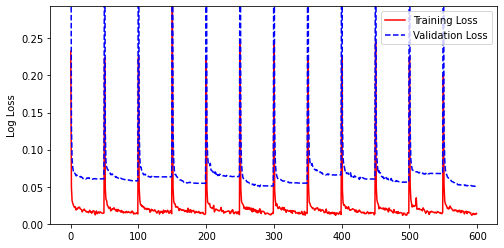

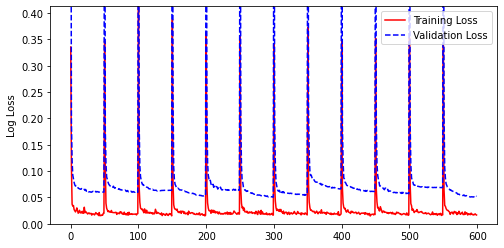

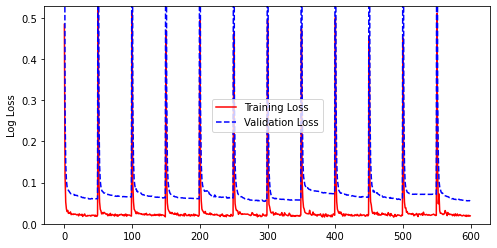

In [15]:
LPT = []
LPV = []

for i in range(len(LP_1)):
    LPT.append(LP_1[i]["train"])
    LPV.append(LP_1[i]["valid"])

LPT = np.array(LPT)
LPT = np.multiply(LPT, cfg.tr_batch_size)
LPV = np.array(LPV)
LPV = np.multiply(LPV, cfg.va_batch_size)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(LP_1)), LPT, "r", label="Training Loss")
plt.plot(np.arange(len(LP_1)), LPV, "b--", label="Validation Loss")
plt.legend()
plt.ylim([0, np.max(LPT)])
plt.ylabel("Log Loss")
plt.show()

################################################################################

LPT = []
LPV = []

for i in range(len(LP_2)):
    LPT.append(LP_2[i]["train"])
    LPV.append(LP_2[i]["valid"])

LPT = np.array(LPT)
LPT = np.multiply(LPT, cfg.tr_batch_size)
LPV = np.array(LPV)
LPV = np.multiply(LPV, cfg.va_batch_size)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(LP_2)), LPT, "r", label="Training Loss")
plt.plot(np.arange(len(LP_2)), LPV, "b--", label="Validation Loss")
plt.legend()
plt.ylim([0, np.max(LPT)])
plt.ylabel("Log Loss")
plt.show()

################################################################################

LPT = []
LPV = []

for i in range(len(LP_2)):
    LPT.append(LP_3[i]["train"])
    LPV.append(LP_3[i]["valid"])

LPT = np.array(LPT)
LPT = np.multiply(LPT, cfg.tr_batch_size)
LPV = np.array(LPV)
LPV = np.multiply(LPV, cfg.va_batch_size)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(LP_3)), LPT, "r", label="Training Loss")
plt.plot(np.arange(len(LP_3)), LPV, "b--", label="Validation Loss")
plt.legend()
plt.ylim([0, np.max(LPT)])
plt.ylabel("Log Loss")
plt.show()